## Neural ODE

In this section, we demostrate how to implement a Neural ODE. The Neural ODE is matched to a simple differential equation.

We are aiming to approximate the set of differential equations:
$$ y_1' = -0.1 y_1 + y_2$$
$$ y_2' = -y_1 - 0.1 y_2$$
In matrix form, this can be expressed for $y=[y_1, y_2]^\top$ as $y'= F(t,y) = Ay$ where
$$A = \left[ \begin{array}{cc} -0.1 & 1.0 \\ -1.0 & -0.1 \end{array} \right].$$

We begin importing the packages that will be used.

### Homework
Xingjian Li

This is modified to the Lorenz System

F now defines the Lorenz System

The neural network is expanded 1 layer, uses AdamW optimizer

The odeint uses rk4 as it is 10x faster than odpri5

The model trains for 30k iterations with first 15k uses a time window of 8 steps (t [0,0.1]), and latter half uses 16 steps for better consistency

The model fits quite well at 24k iteration from the plots, I would say the model managed to learn this non-linear system. 

In [174]:
import torch
import torch.nn as nn
import torchdiffeq
import numpy as np
import matplotlib.pyplot as plt
import time

Defining the initial conditions, time samples and dynamics equation.

In [175]:
# Specifying an initial condition

## modified to lorenz
# x' = sigma * (y - x)
# y' = x * (rho - z) - y
# z' = x * y - beta * z
sigma = 10.0
rho = 28.0
beta = 8.0/3.0
y0 = torch.tensor([[1.,1.,1.]])

# Specifying time samples
N = 2000
tTrain = torch.linspace(0.,25.,N)

# Matrix specifying dynamics
# lorenz is nonlinear
# A = torch.tensor([[-0.1,1.0],[-1.0,-0.1]])

# Class defining the RHS of the diff. eqn.
class F(nn.Module):
    def forward(self,t,y):
        #print(y.shape)
        result = torch.tensor([sigma * (y[:,1] - y[:,0]), 
                               y[:,0] * (rho - y[:,2]) - y[:,1], 
                               y[:,0] * y[:,1] - beta * y[:,2]])
        return result

Defining a helper function to visualize the results.

In [176]:
# Helper function to visualize the data
from mpl_toolkits.mplot3d import Axes3D
def createFig(t, y_true, y_pred=[]):
    fig,axes = plt.subplots(1, 2, figsize=(10, 4), width_ratios=[1, 1])
    #ax = fig.add_subplot(1,2,1)
    # remove the subplots to be set as 3d projections
    axes[1].remove()

    # add the subplots back as 3d projections; rows, cols and index are relative to width_ratios
    axes[1] = fig.add_subplot(1, 2, 2, projection='3d')
    #ax = plt.axes(projection = '3d')
    axes[1].plot(y_true[:, 0], y_true[:, 1], y_true[:, 2])
    
    #ax.plot(t,y_true[:,0],'-',color='tab:blue',linewidth=2)
    #ax.plot(t,y_true[:,1],'-',color='tab:orange',linewidth=2)
    axes[0].plot(y_true[:,0])
    axes[0].plot(y_true[:,1])
    axes[0].plot(y_true[:,2])
    if(len(y_pred)>0):
        axes[0].plot(y_pred[:,0])
        axes[0].plot(y_pred[:,1])
        axes[0].plot(y_pred[:,2])
        axes[1].plot(y_pred[:, 0], y_pred[:, 1], y_pred[:, 2])
    
    
    #    ax.plot(t,y_pred[:,1],'--',color='tab:orange')
    # ax.set_title('Trajectories')
    # ax = fig.add_subplot(1,2,2)
    # ax.plot(y_true[:,0],y_true[:,1],'-',color='tab:green',linewidth=2)
    # if(len(y_pred)>0):
    #     ax.plot(y_pred[:,0],y_pred[:,1],'--',color='tab:green')
    # ax.set_title('Phase Plot')

    return fig

Solving the differential equation and showing the results. This is our training data.

Initial Dimensions: (2000, 1, 3)
Updated Dimensions: (2000, 3)


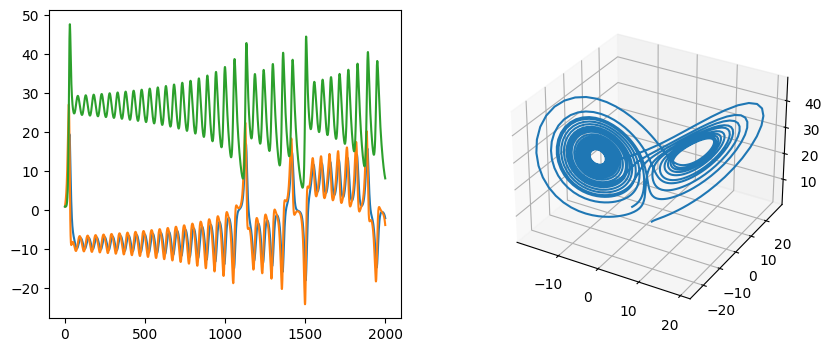

In [177]:
from torchdiffeq import odeint_adjoint as odeint

# Solving the differential equation
with torch.no_grad():
    yTrain_tensor = odeint(F(), y0, tTrain, method='rk4') # dopri5 is a version of RK of order 5

# Reformatting the output
yTrain = yTrain_tensor.numpy()
print('Initial Dimensions:', yTrain.shape)
yTrain = np.squeeze(yTrain)
print('Updated Dimensions:', yTrain.shape)

# Plotting the output
fig = createFig(tTrain,yTrain)
plt.show()

Defining a function to batch the data during sampling, and specifying the function $f$ from the Neural ODE that will be integrated.

In [186]:
# Specifying the number of samples in a batch
batch_size = 20
# Specifying the same of the window of points taken for each sample in a batch
batch_time = 10

# Function for getting a minibatch of data. It extract bath_size windows of size batch_time. The
# returned batch_time is just the relative time from the initial condition specified by batch_y0.
def mini_batch(batch_size,batch_time):
    s_temp = np.arange(N - batch_time, dtype = np.int64)
    s = torch.from_numpy(np.random.choice(s_temp, batch_size, replace=False))
    batch_y0 = yTrain_tensor[s]  # (M, D)  # Batch_time
    batch_t = tTrain[:batch_time]  # (T)
    batch_y = torch.stack([yTrain_tensor[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    #print(batch_y0, batch_t, batch_y)
    return batch_y0, batch_t, batch_y

# Specifying an ODEFunc that will be learned and integrated.
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        # Defining a two layer MLP with tanh activation
        self.net = nn.Sequential(
            nn.Linear(3, 40),   # modify from 2 input/output to 3 input/output
            nn.Tanh(),
            nn.Linear(40, 40),
            nn.Tanh(),
            nn.Linear(40, 40),
            nn.Tanh(),
            nn.Linear(40, 3),
        )
        ## Providing a specific initialization of the weights and biases
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)

Displaying the output of the minibatch function.

In [179]:
batch_y0, batch_t, batch_y = mini_batch(batch_size = 4,batch_time = 3)
tmp = batch_y0.numpy()
print('Initial Conditions')
print(tmp.shape,'\n',np.squeeze(tmp))
tmp = batch_t.numpy()
print('\nTimestamps for the windows of data')
print(tmp.shape,'\n',np.squeeze(tmp))
tmp = batch_y.numpy()
print('\nValues on the Mini-Batch')
print(tmp.shape,'\n',np.squeeze(tmp))

Initial Conditions
(4, 1, 3) 
 [[-3.7719886 -4.9991703 18.526308 ]
 [-5.133305  -2.9308457 26.370117 ]
 [17.913412  26.687807  31.16101  ]
 [ 7.9381223  0.9803171 33.658916 ]]

Timestamps for the windows of data
(3,) 
 [0.         0.01250625 0.02501251]

Values on the Mini-Batch
(3, 4, 1, 3) 
 [[[-3.7719886 -4.9991703 18.526308 ]
  [-5.133305  -2.9308457 26.370117 ]
  [17.913412  26.687807  31.16101  ]
  [ 7.9381223  0.9803171 33.658916 ]]

 [[-3.93997   -5.399694  18.165108 ]
  [-4.87922   -3.0169148 25.687994 ]
  [18.858974  25.06652   36.01966  ]
  [ 7.089036   0.4874458 32.62174  ]]

 [[-4.1373024 -5.8341894 17.848179 ]
  [-4.6671352 -3.1360989 25.025726 ]
  [19.433393  22.299389  40.444138 ]
  [ 6.2908072  0.1400761 31.576815 ]]]


Fitting the Neural ODE.

 10%|▉         | 2998/30000 [03:09<28:01, 16.06it/s]

Iteration - 3000. Loss: 2.0147743225097656


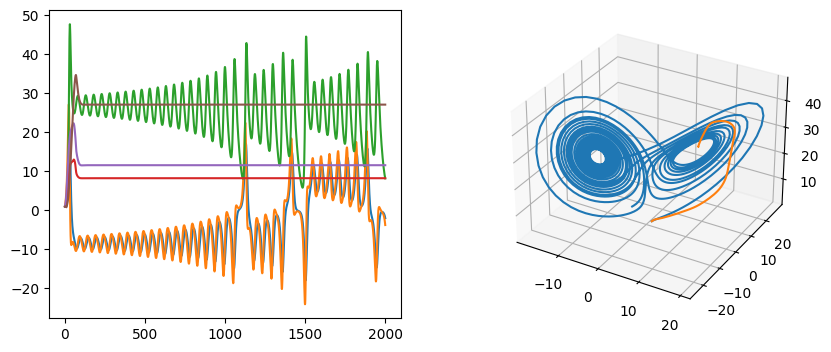

 20%|█▉        | 5999/30000 [06:23<25:54, 15.44it/s]  

Iteration - 6000. Loss: 1.1389631032943726


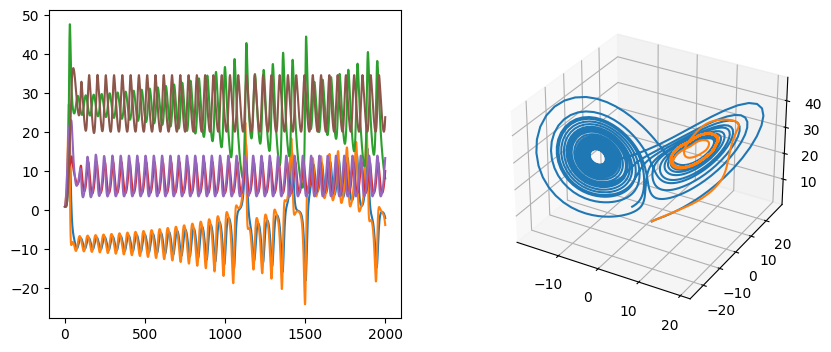

 30%|██▉       | 8998/30000 [09:35<22:56, 15.26it/s]  

Iteration - 9000. Loss: 0.683946967124939


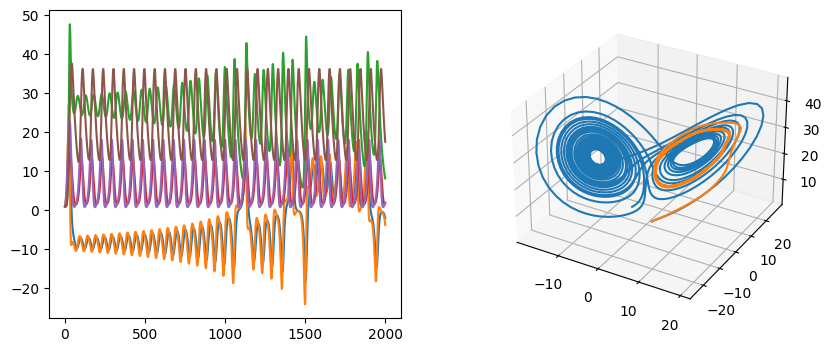

 40%|███▉      | 11999/30000 [12:44<18:29, 16.23it/s] 

Iteration - 12000. Loss: 0.2408982366323471


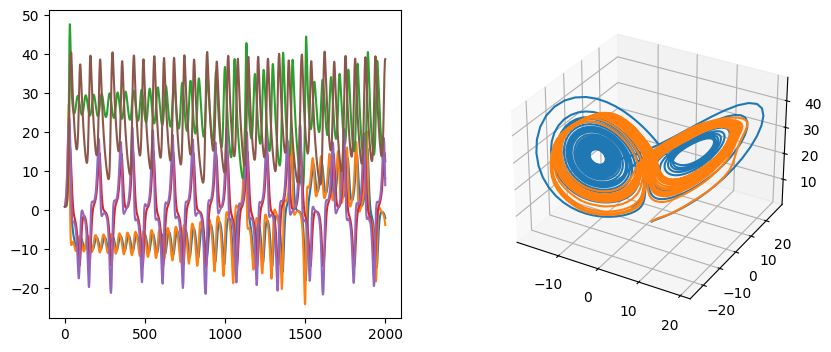

 50%|████▉     | 14998/30000 [15:52<15:41, 15.93it/s]  

Iteration - 15000. Loss: 0.06718622893095016


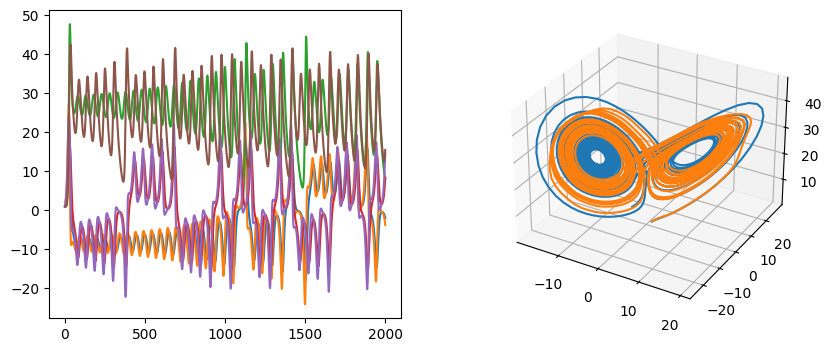

 60%|█████▉    | 17999/30000 [21:58<25:46,  7.76it/s]  

Iteration - 18000. Loss: 0.12100130319595337


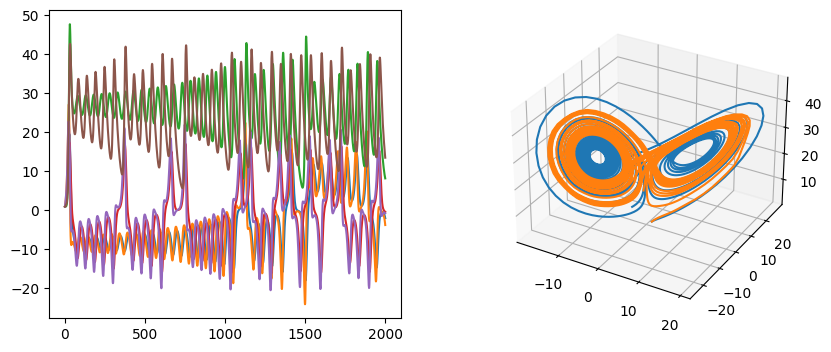

 70%|██████▉   | 20999/30000 [28:15<18:26,  8.13it/s]  

Iteration - 21000. Loss: 0.05173327773809433


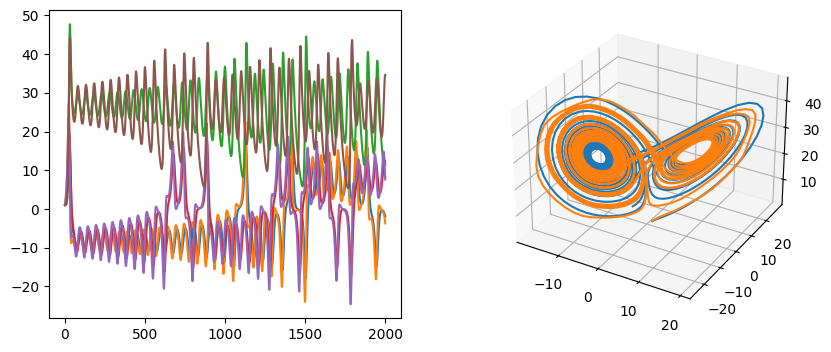

 80%|███████▉  | 23999/30000 [34:23<11:45,  8.50it/s]  

Iteration - 24000. Loss: 0.03389006480574608


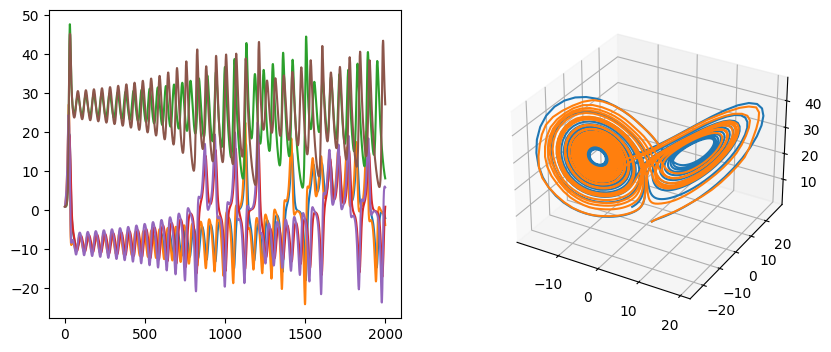

 90%|████████▉ | 26999/30000 [40:30<06:09,  8.12it/s]  

Iteration - 27000. Loss: 0.03767842799425125


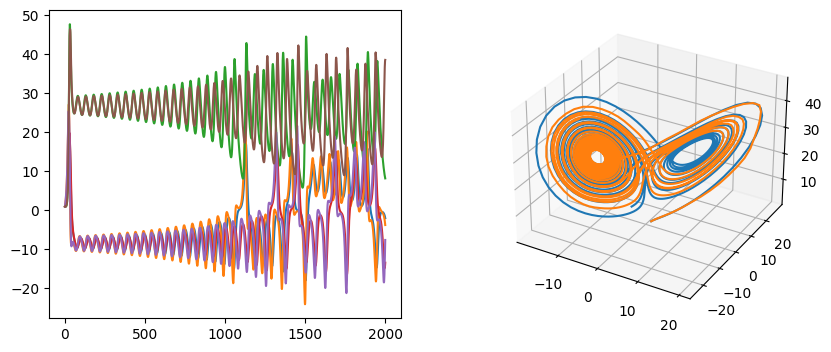

100%|█████████▉| 29999/30000 [46:42<00:00,  8.03it/s]  

Iteration - 30000. Loss: 0.024606039747595787


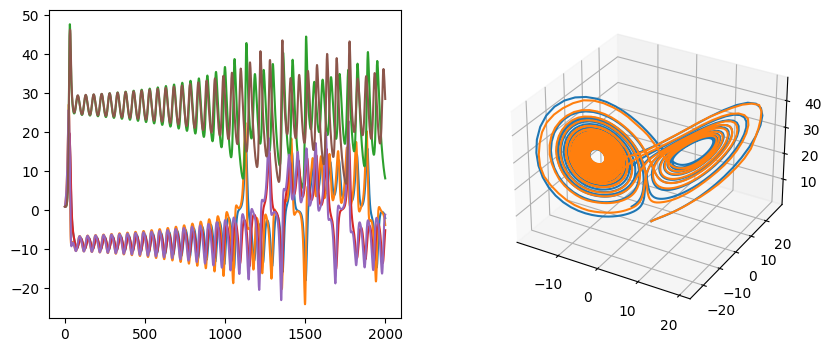

100%|██████████| 30000/30000 [46:42<00:00, 10.71it/s]


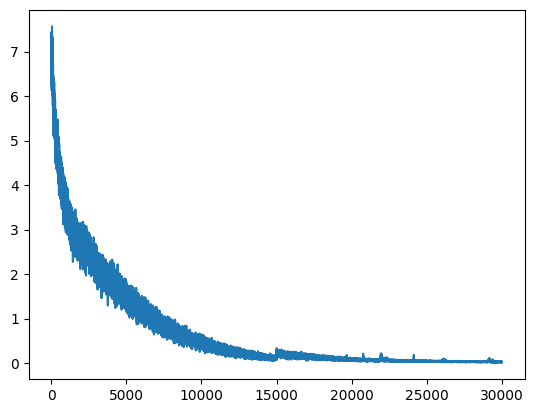

In [192]:
import torch.optim as optim
from tqdm import tqdm
# Creating an instance of the neural network and the optimizer
func = ODEFunc().cuda()
optimizer = optim.AdamW(func.parameters(), lr=1e-3)
criterion = nn.MSELoss()
# Specifying the number of iterations on the optimization
Niter = 30000
losses = []
for it in tqdm(range(1,Niter+1)):
    optimizer.zero_grad()
    if it > 15000:
        batch_y0, batch_t, batch_y = mini_batch(batch_size=1024, batch_time=16)
    else:
        batch_y0, batch_t, batch_y = mini_batch(batch_size=1024, batch_time=8)
    pred = odeint(func,batch_y0.cuda(),batch_t.cuda(),method="rk4")
    loss = criterion(pred,batch_y.cuda())
    loss.backward()
    torch.nn.utils.clip_grad_norm_(func.parameters(), max_norm=1.0)

    optimizer.step()
    losses.append(loss.item())
    if it%3000==0:
        with torch.no_grad():
            pred = odeint(func, y0.cuda(), tTrain.cuda(),method="rk4")
            fig = createFig(tTrain,yTrain,np.squeeze(pred.detach().cpu().numpy()))
            tqdm.write(f'Iteration - {it}. Loss: {loss.item()}')
            plt.show()
plt.plot(losses)
plt.show()